In [1]:
import fastText
from fastText.util.util import find_nearest_neighbor
import pandas as pd
import re
import numpy as np
import csv
import os
from scipy import stats
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### Data preprocessing

In [2]:
df = pd.read_csv('data/amazon_reviews.csv')
df = df[['Score', 'Text']]
df['Text'] = df['Text'].apply(lambda x: re.sub(r"([.\\!?,'/()])", r" \1 ", x.lower()))

In [3]:
with open('data/ft_amazon_review_sg.txt', 'w') as f:
    for line in df['Text'].values:
        f.write(line)
        f.write('\n')

### Model training

#### Skipgram model

In [4]:
sg_model = fastText.train_unsupervised(input='data/ft_amazon_review_sg.txt', model='skipgram')

#### CBOW model

In [5]:
cbow_model = fastText.train_unsupervised(input='data/ft_amazon_review_sg.txt', model='cbow')

### Model Evaluation

#### Printing word vectors

In [6]:
sg_model.get_word_vector('chocolate')

array([ 0.28885147,  0.34310964, -0.06068458, -0.5658382 , -0.25672913,
        0.41507494,  0.1411262 , -0.11142749,  0.5796311 ,  0.05652755,
       -0.41198856,  0.2445084 ,  0.20226298,  0.22466432,  0.00869949,
       -0.42456797,  0.14835362, -0.38931805, -0.170336  , -0.15083621,
        0.09204759, -0.11345511,  0.15903142,  0.41930065, -0.17932999,
       -0.579378  ,  0.07560825,  0.53409725, -0.20587127,  0.25352234,
       -0.395235  ,  0.12970044, -0.2440243 , -0.21013793,  0.21134807,
       -0.10953298, -0.24550655,  0.23024896, -0.48733202, -0.24536018,
        0.16880575,  0.01380736,  0.02415508,  0.33492976, -0.10089339,
        0.03441795, -0.7054811 , -0.6926563 ,  0.32579902,  0.83706576,
       -0.22618887, -0.18367031,  0.09906393,  0.28151816,  0.00969056,
        0.22166236,  0.09444915, -0.3030114 , -0.1318249 ,  0.28401542,
       -0.11216401, -0.13406882, -0.01469294,  0.09450608,  0.12833421,
        0.34177524,  0.14439605, -0.12185214,  0.155795  ,  0.00

In [7]:
print(sg_model.get_subwords('something'))

(['something', '<so', '<som', '<some', '<somet', 'som', 'some', 'somet', 'someth', 'ome', 'omet', 'ometh', 'omethi', 'met', 'meth', 'methi', 'methin', 'eth', 'ethi', 'ethin', 'ething', 'thi', 'thin', 'thing', 'thing>', 'hin', 'hing', 'hing>', 'ing', 'ing>', 'ng>'], array([    168, 1748605,  623824, 1031135,  992673,  491062, 1290905,
        219015,   88509, 1290412, 1992184,  616400, 1709691, 1420625,
       1547131,  490230,  150536, 1329700,  985911,  363099, 1243108,
       2035600, 2038170,  420919,  557515,   93124,  238793,  299125,
        834851,  653895,  280444]))


#### Nearest Neighbor Queries

In [25]:
def get_nn_words(question, cossims, model, words, vectors, k=1):
    question = question.lower().strip()
    if question not in words:
        print(question, ' not in vocabulary')
    query = question
    query = model.get_word_vector(query)
    query = query / np.linalg.norm(query)
    seen_words = [question]
    for _ in range(k):
        ban_set = list(map(lambda x: words.index(x), seen_words))
        nn = words[find_nearest_neighbor(query, vectors, ban_set, cossims=cossims)]
        seen_words.append(nn)
        yield nn

def nn(model, question_words, k, threshold=100000):
    # Gets words with associated frequeny sorted by default by descending order
    words, freq = model.get_words(include_freq=True)
    words = words[:threshold]
    vectors = np.zeros((len(words), model.get_dimension()), dtype=float)
    for i in range(len(words)):
        wv = model.get_word_vector(words[i])
        wv = wv / np.linalg.norm(wv)
        vectors[i] = wv

    # For efficiency preallocate the memory to calculate cosine similarities
    cossims = np.zeros(len(words), dtype=float)
    if isinstance(question_words, str):
        questions = question_words.split(',')
    elif isinstance(question_words, list):
        questions = question_words
    else:
        raise ValueError('please give question_words as a comma separated string or list')
    for question in questions:
        print('words similar to {}:'.format(question))
        for w in get_nn_words(question, cossims, model, words, vectors, k):
            print(w)
        print('#########################################')

In [26]:
nn(sg_model, ['dog', 'pizza', 'hungry'], k=5)

words similar to dog:
dogs
pup
puppy
treats
v-dog
#########################################
words similar to pizza:
pizza;
pizzas
pizza"
boboli
"pizza
#########################################
words similar to hungry:
hungry";
>hungry
hungrygirl
hungry-girl
hungries
#########################################


In [ ]:
print(correct, num_qs, num_lines)

#### Word analogies

#### Word Similarity

You can find similar words by calculating the cosine similarity between the vectors of words. There are many other functions that you can use to find the similarity. There is also the word mover distance which we will take a look at when we are looking at gensim models.

In [28]:
def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

v1 = sg_model.get_word_vector('drink')
v2 = sg_model.get_word_vector('drinks')
print(similarity(v1, v2))

v1 = cbow_model.get_word_vector('drink')
v2 = cbow_model.get_word_vector('drinks')
print(similarity(v1, v2))

0.78552675
0.8144023


#### Model Performance

Quantify the performance of the model using google question words.

In [29]:
# Because of fasttext we don't need to account for OOV
def compute_similarity(data_path, model):
    def similarity(v1, v2):
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        return np.dot(v1, v2) / n1 / n2

    mysim = []
    gold = []

    with open(data_path, 'rb') as fin:
        for line in fin:
            tline = line.split()
            word1 = tline[0].lower()
            word2 = tline[1].lower()

            v1 = model.get_word_vector(word1)
            v2 = model.get_word_vector(word2)
            d = similarity(v1, v2)
            mysim.append(d)
            gold.append(float(tline[2]))

    corr = stats.spearmanr(mysim, gold)
    dataset = os.path.basename(data_path)
    correlation = corr[0] * 100
    return dataset, correlation, 0

In [30]:
dataset, corr, oov = compute_similarity('data/rw/rw.txt', sg_model)
print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)".format(dataset, corr, 0))

rw.txt              : 32  (OOV:  0%)


In [31]:
dataset, corr, oov = compute_similarity('data/rw/rw.txt', cbow_model)
print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)".format(dataset, corr, 0))

rw.txt              : 28  (OOV:  0%)


#### TSNE visualizations

In [32]:
words = ['hot', 'water', 'drink', 'tea', 'cofee', 'cup', 
         'price', 'buy', 'order', 'recommend', 
         'different', 'tried', 'been',  'years',
         'good', 'nice', 'great', 'delicious']

In [33]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it
    inspired from tsne for gensim word2vec: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
    """
    labels = []
    tokens = []

    for word in model.get_words()[20:300]: # not using the first 20 as they are mostly most common words
#     for word in words:
        tokens.append(model.get_word_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    labeling = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
    for index, value in enumerate(new_values):
        if labels[index] in words:
            x.append(value[0])
            y.append(value[1])
            labeling.append(labels[index])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
        plt.annotate(labeling[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

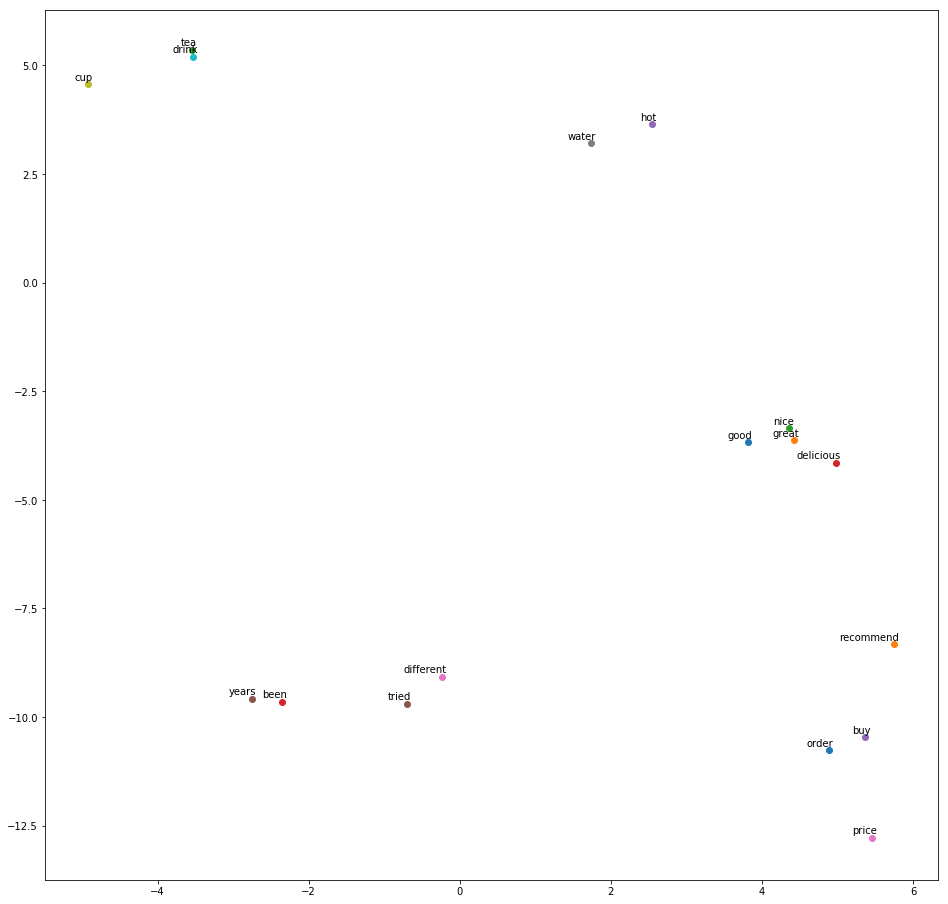

In [34]:
tsne_plot(sg_model)

You can see that the "years", 'different' and 'been' cluster together signifying probably nostalgia; "recommend", "order", "buy" and "price" are probably the considerations that the customer takes in when ordering the item; "good", "delicious", "great", "nice" are clustered together and "hot", "water", "drink", "tea", "cup" seem to go together when people are thinking about drinks and beverages.